<a href="https://colab.research.google.com/github/mn000000/Simulacion-1/blob/main/Inventario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación y Optimización de Inventario

## Importación de librerías necesarias

In [29]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


## Distribución de demanda mensual

In [30]:

# Distribución de demanda mensual
demanda = {
    35: 0.010, 36: 0.015, 37: 0.020, 38: 0.020, 39: 0.022,
    40: 0.023, 41: 0.025, 42: 0.027, 43: 0.028, 44: 0.029,
    45: 0.035, 46: 0.045, 47: 0.060, 48: 0.065, 49: 0.070,
    50: 0.080, 51: 0.075, 52: 0.070, 53: 0.065, 54: 0.060,
    55: 0.050, 56: 0.040, 57: 0.030, 58: 0.016, 59: 0.015, 60: 0.005
}


## Distribución de tiempo de entrega

In [31]:

# Distribución de tiempo de entrega
tiempo_entrega = {
    1: 0.30, 2: 0.40, 3: 0.30
}


## Factores estacionales

In [32]:

# Factores estacionales
factores_estacionales = {
    1: 1.20, 2: 1.00, 3: 0.90, 4: 0.80, 5: 0.80, 6: 0.70,
    7: 0.80, 8: 0.90, 9: 1.00, 10: 1.20, 11: 1.30, 12: 1.40
}


## Costos involucrados en el sistema de inventario

In [33]:

# Costos
costo_ordenar = 100
costo_inventario = 20
costo_faltante = 50


## Inventario inicial

In [34]:

# Inventario inicial
inventario_inicial = 150


## Funciones de demanda y tiempo de entrega

In [35]:

# Funciones
def generar_demanda():
    cantidades = list(demanda.keys())
    probabilidades = list(demanda.values())
    return np.random.choice(cantidades, p=probabilidades)

def generar_tiempo_entrega():
    tiempos = list(tiempo_entrega.keys())
    probabilidades = list(tiempo_entrega.values())
    return np.random.choice(tiempos, p=probabilidades)


## Función para simular el inventario

In [36]:

# Función para simular el inventario
def simular_inventario(meses=12, q=200, R=100):
    inventario = inventario_inicial
    costo_total_ordenar = 0
    costo_total_inventario = 0
    costo_total_faltante = 0
    historial_inventario = []
    historial_pedidos = []
    historial_faltantes = []

    pedidos = []

    for mes in range(1, meses + 1):
        demanda_mes = generar_demanda() * factores_estacionales[mes]

        # Registrar pedidos si llegan en este mes
        if pedidos:
            for pedido in pedidos.copy():
                if pedido[1] == mes:
                    inventario += pedido[0]
                    pedidos.remove(pedido)

        if inventario < R:
            pedido = q
            tiempo_entrega_mes = generar_tiempo_entrega()
            pedidos.append((pedido, mes + tiempo_entrega_mes))
            costo_total_ordenar += costo_ordenar
            historial_pedidos.append((mes, pedido))

        if demanda_mes > inventario:
            faltantes = demanda_mes - inventario
            costo_total_faltante += faltantes * costo_faltante
            inventario = 0
        else:
            faltantes = 0
            inventario -= demanda_mes

        costo_total_inventario += inventario * costo_inventario / 12
        historial_inventario.append(inventario)
        historial_faltantes.append(faltantes)

    costo_total = costo_total_ordenar + costo_total_inventario + costo_total_faltante

    return historial_inventario, historial_pedidos, historial_faltantes, costo_total


## Función objetivo para optimización

In [37]:

# Función objetivo
def objetivo(params):
    q, R = params
    _, _, _, costo_total = simular_inventario(q=int(q), R=int(R))
    return costo_total


## Definición de límites y condiciones iniciales

In [38]:

# Límites y condiciones iniciales
limites = [(50, 250), (50, 200)]
condiciones_iniciales = [100, 100]


## Ejecución

In [39]:

# Ejecución de optimización
resultado = minimize(objetivo, condiciones_iniciales, bounds=limites, method='L-BFGS-B')
mejor_q, mejor_R = resultado.x

print(f'Cantidad óptima a ordenar (q): {int(mejor_q)}')
print(f'Nivel óptimo de reorden (R): {int(mejor_R)}')
print(f'Costo total mínimo: ${resultado.fun:.2f}')


Cantidad óptima a ordenar (q): 99
Nivel óptimo de reorden (R): 99
Costo total mínimo: $4997.33


## Ejecución de simulación con valores óptimos

In [40]:

# Simulación con valores óptimos
historial_inventario, historial_pedidos, historial_faltantes, costo_total = simular_inventario(q=int(mejor_q), R=int(mejor_R))


## Resultados

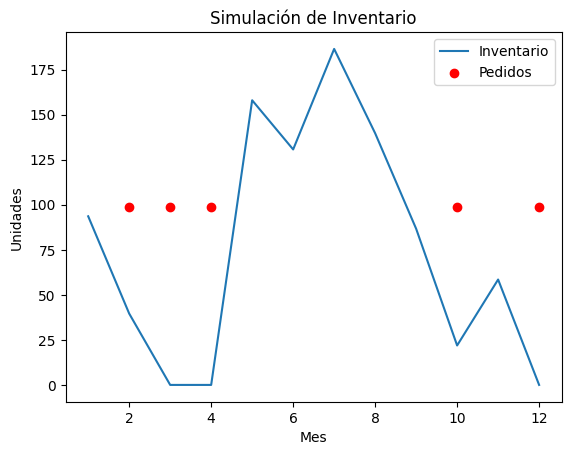

Costo total: $4695.33


In [41]:

# Observación de los resultados
meses = range(1, 13)
plt.plot(meses, historial_inventario, label='Inventario')
plt.scatter(*zip(*historial_pedidos), color='red', label='Pedidos')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.title('Simulación de Inventario')
plt.legend()
plt.show()

print(f'Costo total: ${costo_total:.2f}')
